In [676]:
import math
import multiprocessing
import os
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import scipy.ndimage
import skimage.color
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
from tqdm.autonotebook import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cdist



## 16-720 Computer Vision: Homework 1 (Spring 2022)
## Spatial Pyramid Matching for Scene Classification

In [677]:
class Opts(object):
    def __init__(
        self,
        data_dir="../data",
        feat_dir="../feat",
        out_dir=".",
        filter_scales=(1, 2),
        K=150,
        alpha=150,
        L=3,
    ):
        '''
        Manage tunable hyperparameters.

        You can also add your own additional hyperparameters.

        [input]
        * data_dir: Data directory.
        * feat_dir: Feature directory.
        * out_dir: Output directory.
        * filter_scales: A list of scales for all the filters.
        * K: Number of words.
        * alpha: Subset of alpha pixels in each image.
        * L: Number of layers in spatial pyramid matching (SPM).

        '''
        self.data_dir = data_dir
        self.feat_dir = feat_dir
        self.out_dir = out_dir
        self.filter_scales = list(filter_scales)
        self.K = K
        self.alpha = alpha
        self.L = L

opts = Opts()

In [678]:
# utils

def get_num_CPU():
    '''
    Counts the number of CPUs available in the machine.
    '''
    return multiprocessing.cpu_count()


def display_filter_responses(opts, response_maps):
    '''
    Visualizes the filter response maps.

    [input]
    * response_maps: a numpy.ndarray of shape (H,W,3F)
    '''

    n_scale = len(opts.filter_scales)
    plt.figure()

    for i in range(n_scale * 4):
        plt.subplot(n_scale, 4, i + 1)
        resp = response_maps[:, :, i * 3:i * 3 + 3]
        resp_min = resp.min(axis=(0, 1), keepdims=True)
        resp_max = resp.max(axis=(0, 1), keepdims=True)
        resp = (resp - resp_min) / (resp_max - resp_min)
        plt.imshow(resp)
        plt.axis("off")

    plt.subplots_adjust(left=0.05, right=0.95, top=0.95,
                        bottom=0.05, wspace=0.05, hspace=0.05)
    plt.show()


def visualize_wordmap(original_image, wordmap, out_path=None):
    fig = plt.figure(figsize=(12.8, 4.8))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(original_image)
    plt.axis("off")
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(wordmap)
    plt.axis("off")
    plt.show()
    if out_path:
        plt.savefig(out_path, pad_inches=0)


## Question 1

## Q1.1.1



(1) Gaussian - It results in the blurring of an image. This filter is used to reduce image noise and reduce the detail of images.

(2) Laplacian of Gaussian - Laplacian detects intensity changes and thus is used as an edge detector. It is normally applied after the image has been smoothed out by a gaussian to reduce sensitivity to noise.

(3) Derivative of Gaussian in the x-direction - Detects gradient changes in the x-direction, and thus is used as a vertical edge detector.

(4) Derivative of Gaussian in the y-direction -  Detects gradient changes in the y-direction, and thus is used as a horizontal edge detector.

We need multiple scales of filters because we need to capture features at different scales. Edges and features detected on one scale may not be detected on other scales.


## Q1.1.2

In [679]:
def extract_filter_responses(opts, img):
    '''
    Extracts the filter responses for the given image.

    [input]
    * opts    : options
    * img    : numpy.ndarray of shape (H,W) or (H,W,3)
    [output]
    * filter_responses: numpy.ndarray of shape (H,W,3F)
    '''
    
    h = img.shape[0]
    w = img.shape[1]
    channels = img.shape[2]
    n_scales = len(opts.filter_scales)
    f =  4*3*n_scales
    
    # If greyscale image
    
    if(channels == 1):
        cp = img[:,:,0]
        cp[:,:,1] = img[:,:,0]
        cp[:,:,2] = img[:,:,0]
        
        img = cp
    
    # If more than 3 channels
    
    if(channels > 3):
        img = img[:,:,0:3]
    

    img = img.astype(float) / 255.
    skimage.color.rgb2lab(img)

    filter_responses = np.empty((h,w,f))
    filter_scales = opts.filter_scales
    
    # ----- TODO -----
    ind = 0
    for i in filter_scales :
        
        for j in range(3):
            
            result = scipy.ndimage.gaussian_filter(img[:,:,j],i)
            filter_responses[:,:,ind] = result
            ind = ind + 1
        
        for j in range(3):
            
            result = scipy.ndimage.gaussian_laplace(img[:,:,j],i)
            filter_responses[:,:,ind] = result
            ind = ind + 1
                    
        for j in range(3):
            
            result = scipy.ndimage.gaussian_filter(img[:,:,j],i,order = [0,1])
            filter_responses[:,:,ind] = result
            ind = ind + 1
            
        for j in range(3):
            
            result = scipy.ndimage.gaussian_filter(img[:,:,j],i,order = [1,0])
            filter_responses[:,:,ind] = result
            ind = ind + 1
            

    return filter_responses

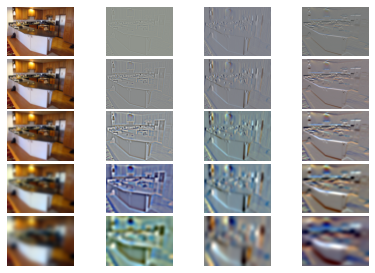

In [680]:
# Should have filters for at least 3 scales.

opts.filter_scales = [1, 2, 4, 8, 16]
img_path = join(opts.data_dir, 'kitchen/sun_aasmevtpkslccptd.jpg')
img = plt.imread(img_path)
filter_responses = extract_filter_responses(opts, img)
display_filter_responses(opts, filter_responses)

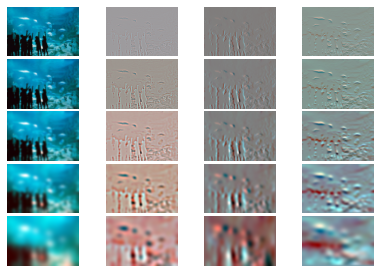

In [681]:
# Should have filters for at least 3 scales.

img_path = join(opts.data_dir, 'aquarium/sun_aztvjgubyrgvirup.jpg')
img = plt.imread(img_path)
filter_responses = extract_filter_responses(opts, img)
display_filter_responses(opts, filter_responses)

## Q1.2

In [682]:
def compute_dictionary_one_image(args):
    """
    Extracts a random subset of filter responses of an image and save it to disk
    This is a worker function called by compute_dictionary

    Your are free to make your own interface based on how you implement compute_dictionary
    """
    opts, idx, img_path = args
    
    img = plt.imread(img_path)
    image_responses = extract_filter_responses(opts, img)
    filter_responses = np.empty((opts.alpha,4*3*len(opts.filter_scales)))

    h = img.shape[0]
    w = img.shape[1]
    pixel = [] # This is an array containing the samples alpha coorrdinate points
    count = h*w -1
    for i in range(opts.alpha):
        temp = np.random.randint(0,count)
        column = temp % w
        row    = int(temp / w)
        coord = [row,column]
        pixel.append(coord)
       
    pixel_count = 0
    for i in pixel:
        r = i[0]
        c = i[1]
        temp = image_responses[r,c,:]
        filter_responses[pixel_count,:] = temp
        pixel_count +=1
        
    name = "feat" + str(idx)
    np.save(os.path.join(opts.feat_dir, name),filter_responses)


def compute_dictionary(opts, n_worker=1):
    """
    Creates the dictionary of visual words by clustering using k-means.

    [input]
    * opts         : options
    * n_worker     : number of workers to process in parallel

    [saved]
    * dictionary : numpy.ndarray of shape (K,3F)
    """

    
    data_dir = opts.data_dir
    feat_dir = opts.feat_dir
    out_dir = opts.out_dir
    K = opts.K

    train_files = open(join(data_dir, "train_files.txt")).read().splitlines()
    
    image_count = 1
    for i in train_files :
        print("Image count :", image_count)
        imgpath = join(data_dir, i)
        args = [opts,image_count,imgpath]
        compute_dictionary_one_image(args)
        image_count +=1

    
    filter_responses = np.zeros((opts.alpha,4*3*len(opts.filter_scales)))
    file_count = 0
    for filename in os.listdir(feat_dir):
        if filename.endswith('.npy'):
            if(file_count == 0):
                
                filter_responses[:,:] = np.load(os.path.join(feat_dir,filename))
                file_count+=1
                
            else:
                
                filter_responses = np.vstack((filter_responses,np.load(os.path.join(feat_dir,filename))))
                file_count +=1
                
    kmeans = KMeans(n_clusters=K).fit(filter_responses)
    dictionary = kmeans.cluster_centers_
    
    np.save('dictionary',dictionary)

 

In [ ]:
n_cpu = get_num_CPU()
compute_dictionary(opts, n_worker=n_cpu)

In [684]:
dictt = np.load('dictionary.npy')
print(dictt.shape)

(150, 60)


## Q1.3

The wordmap shows the contours in each image. Words change along the edges and tend to stay the same for homogenous regions.

In [685]:
def get_visual_words(opts, img, dictionary):
    """
    Compute visual words mapping for the given img using the dictionary of visual words.

    [input]
    * opts    : options
    * img    : numpy.ndarray of shape (H,W) or (H,W,3)

    [output]
    * wordmap: numpy.ndarray of shape (H,W)
    """

    # ----- TODO -----
    
    filter_responses = extract_filter_responses(opts,img)
    h = filter_responses.shape[0]
    w = filter_responses.shape[1]
    f = filter_responses.shape[2]
    filter_responses = np.reshape(filter_responses, (-1, f))
    dis = cdist( filter_responses, dictionary)
    test = dis[:2]
    minim = np.argmin(test)
    wordmap = np.argmin(dis,axis=1) # Columns = 1 - > Values between 1 and k 
    wordmap= wordmap.reshape(h,w)
    

    return wordmap


In [686]:
# dictionary = np.load(join(opts.out_dir, 'dictionary.npy'))
dictionary = np.load('dictionary.npy')

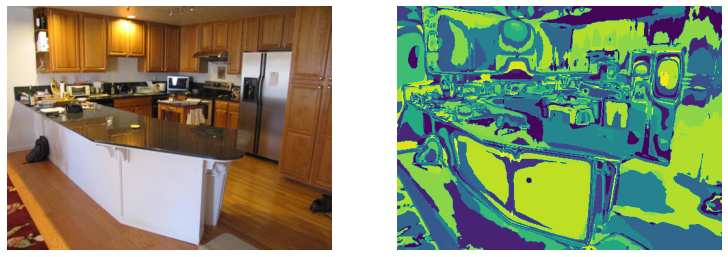

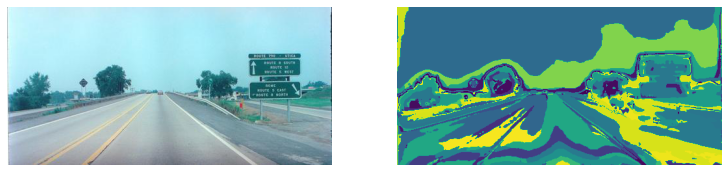

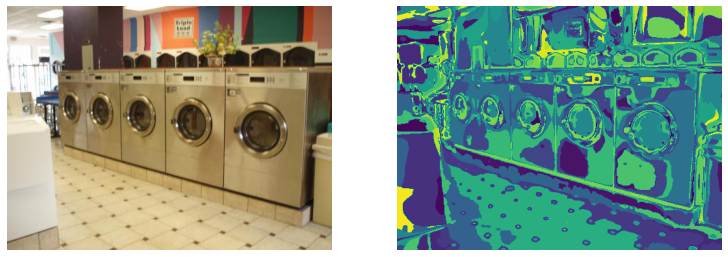

In [687]:
img_path = join(opts.data_dir, 'kitchen/sun_aasmevtpkslccptd.jpg')
img = plt.imread(img_path)
wordmap = get_visual_words(opts, img, dictionary)
visualize_wordmap(img, wordmap)

img_path = join(opts.data_dir, 'highway/sun_ailjxpgyepocjdos.jpg')
img = plt.imread(img_path)
wordmap = get_visual_words(opts, img, dictionary)
visualize_wordmap(img, wordmap)

img_path = join(opts.data_dir, 'laundromat/sun_aabvooxzwmzzvwds.jpg')
img = plt.imread(img_path) 
wordmap = get_visual_words(opts, img, dictionary)
visualize_wordmap(img, wordmap)



The visualizations makes sense as you can see the edges and corners of the objects in the images in the wordmaps.


## Q2.1

In [688]:
def get_feature_from_wordmap(opts, wordmap):
    '''
    Compute histogram of visual words.

    [input]
    * opts      : options
    * wordmap   : numpy.ndarray of shape (H,W)

    [output]
    * hist: numpy.ndarray of shape (K)
    '''

    K = opts.K
    # ----- TODO -----
    bins = np.arange(1+K)
    hist , b = np.histogram(wordmap,bins, density=True)
    hist = hist/ np.sum(hist) #Normalize the histogram
    
    return hist

In [689]:
# get_feature_from_wordmap(opts, wordmap)

## Q2.2



In [690]:
def get_feature_from_wordmap_SPM(opts, wordmap):
    """
    Compute histogram of visual words using spatial pyramid matching.

    [input]
    * opts      : options
    * wordmap   : numpy.ndarray of shape (H,W)

    [output]
    * hist_all: numpy.ndarray of shape (K*(4^L-1)/3)
    """

    K = opts.K
    L = opts.L
    
    weights = []
    for i in range(L+1):
        power = 0.0
        if(i ==0 or i ==1):
            power = float(1.0/2**L)
            weights.append(power)
            
        else:
            power = (2.0**(i-L-1))
            weights.append(power)
            
    weights = np.asarray(weights)
    
    max_rows = 2**L
    max_cols = 2**L
    
    h = wordmap.shape[0]
    w = wordmap.shape[1]
        
    histogram_L = np.zeros((max_rows,max_cols,K))
    output = []
    
    for i in range(L,-1,-1):
        
        n_row = 2**i
        n_col = 2**i
        hei = int(h/n_row) #size of img height being considered
        wid = int(w/n_col)
        step = int(max_rows/n_row)
        output_new = []
        histogram_new = []
        
        if(i == L):
            
            for j in range(n_row):
                for k in range(n_col):
                    ri = j*hei
                    ro = (j+1)*hei
                    ci = k*wid
                    co = (k+1)*wid
                    sub = wordmap[ri:ro,ci:co ]
                    feat =   get_feature_from_wordmap(opts, sub)
                    histogram_L[j,k,:] = feat
                    feat = feat * weights[i]
                    output = np.hstack((output,feat))
                    
        else :
            
            for j in range(n_row):
                for k in range(n_col):
                    ri = j*step
                    ro = (j+1)*step
                    ci = k*step
                    co = (k+1)*step
                    histogram_new = histogram_L[ri:ro,ci:co,: ]
                    histogram_new = np.sum(histogram_new, axis = 0)
                    histogram_new = np.sum(histogram_new, axis = 0)

                    output_new= np.hstack([output_new, histogram_new*weights[i]])
                    
        output= np.hstack([output,output_new])      
        
    
    
    
    output = output / np.sum(output)
    hist_all = output
    return hist_all

## Q2.3

In [691]:
def distance_to_set(word_hist, histograms):
    """
    Compute the distance between a histogram of visual words with all training image histograms.

    [input]
    * word_hist: numpy.ndarray of shape (K)
    * histograms: numpy.ndarray of shape (N,K)

    [output]
    * dists: numpy.ndarray of shape (N)
    """

    n = histograms.shape[0]
    cp_matrix = np.tile(word_hist,(n,1)) # get k*n matrix to do minimum compare
    min_matrix = np.minimum(cp_matrix,histograms)
    similarity = np.sum(min_matrix,axis = 1)
    dists = 1 - similarity
        
    return dists

## Q2.4

In [692]:
def get_image_feature(opts, img_path, dictionary):
    """
    Extracts the spatial pyramid matching feature.

    [input]
    * opts      : options
    * img_path  : path of image file to read
    * dictionary: numpy.ndarray of shape (K, 3F)


    [output]
    * feature: numpy.ndarray of shape (K)
    """

    # ----- TODO -----
    img = plt.imread(img_path)
    wordmap = get_visual_words(opts, img, dictionary)
    features = get_feature_from_wordmap_SPM(opts, wordmap)
    return features

In [693]:
def build_recognition_system(opts, n_worker=1):
    """
    Creates a trained recognition system by generating training features from all training images.

    [input]
    * opts        : options
    * n_worker  : number of workers to process in parallel

    [saved]
    * features: numpy.ndarray of shape (N,M)
    * labels: numpy.ndarray of shape (N)
    * dictionary: numpy.ndarray of shape (K,3F)
    * SPM_layer_num: number of spatial pyramid layers
    """

    data_dir = opts.data_dir
    out_dir = opts.out_dir
    SPM_layer_num = opts.L

    train_files = open(join(data_dir, "train_files.txt")).read().splitlines()
    train_labels = np.loadtxt(join(data_dir, "train_labels.txt"), np.int32)
    dictionary = np.load(join(out_dir, "dictionary.npy"))
    features = []
    i_count = 0
    for i in train_files :
        print("Image count is :", i_count)
        a = join(data_dir,i)
        feat = get_image_feature(opts, a, dictionary)
        if(i_count ==0):
            features = feat
            features = np.asarray(features)
            i_count+=1
        else:
            features = np.vstack((features,feat))
            i_count+=1

    np.savez_compressed(join(out_dir, 'trained_system.npz'),
        features=features,
        labels=train_labels,
        dictionary=dictionary,
        SPM_layer_num=SPM_layer_num,
    )


In [ ]:
build_recognition_system(opts, n_worker=n_cpu)


## Q2.5

In [696]:
def evaluate_recognition_system(opts, n_worker=1):
    """
    Evaluates the recognition system for all test images and returns the confusion matrix.

    [input]
    * opts        : options
    * n_worker  : number of workers to process in parallel

    [output]
    * conf: numpy.ndarray of shape (8,8)
    * accuracy: accuracy of the evaluated system
    """

    data_dir = opts.data_dir
    out_dir = opts.out_dir

    trained_system = np.load(join(out_dir, "trained_system.npz"))
    dictionary = trained_system["dictionary"]
  
    # using the stored options in the trained system instead of opts.py
    test_opts = copy(opts)
    test_opts.K = dictionary.shape[0]
    test_opts.L = trained_system["SPM_layer_num"]
    train_labels = trained_system["labels"]
    train_features = trained_system["features"]
    test_files = open(join(data_dir, "test_files.txt")).read().splitlines()
    test_labels = np.loadtxt(join(data_dir, "test_labels.txt"), np.int32)
    test_labels = np.asarray(test_labels)

    pred_labels = []
    distances = []
    argminses = []
    
    
    for img in test_files:
        
        img_path = data_dir + "/" + img
        word_hist = get_image_feature(test_opts, img_path, dictionary)
        distance = distance_to_set(word_hist, train_features)
        distances.append(distance)
        argmin = np.argmin(distance)
        argminses.append(argmin)
        pred = train_labels[argmin]
        pred_labels.append(pred)
        
        
    pred_labels = np.asarray(pred_labels)
    conf=confusion_matrix(test_labels, pred_labels)
    accuracy = accuracy_score(test_labels,pred_labels)

    
    return conf, accuracy, pred_labels, test_labels, test_files

In [697]:
conf, accuracy,pred_labels, test_labels, test_files = evaluate_recognition_system(opts, n_worker=1)

print("Accuracy:", accuracy)
classes = [
    "aquarium", "desert", "highway", "kitchen",
    "laundromat", "park", "waterfall", "windmill",
]
df = pd.DataFrame(conf, columns=classes)
df.insert(0, "", classes)
df

TEST LABEL SIZE  (400,)
Accuracy: 0.6625


,,aquarium,desert,highway,kitchen,laundromat,park,waterfall,windmill
0,aquarium,41,0,1,1,3,0,3,1
1,desert,1,25,6,8,4,4,0,2
2,highway,1,4,29,0,0,7,1,8
3,kitchen,3,2,0,33,9,0,3,0
4,laundromat,0,2,1,12,33,1,1,0
5,park,4,0,0,0,0,42,1,3
6,waterfall,1,0,2,1,2,9,33,2
7,windmill,1,2,9,0,1,6,2,29


ACCURACY IS 66.25%


## Q2.6



In [698]:
flag = 1
eg1 = 0
eg2 = 0
eg3 = 0
count = 0
while(flag):
    
    if(test_labels[count] == 3 and pred_labels[count] == 4):
        eg1 = count
        break
    count +=1
    
count = 0
while(flag):
    
    if(test_labels[count] == 4 and pred_labels[count] == 3):
        eg2 = count
        break
    count +=1
    
count = 0
while(flag):
    
    if(test_labels[count] == 5 and pred_labels[count] == 6):
        eg3 = count
        break
    count +=1
    

    

(1) Kitchen misclassified as Laundromat
(2) Laundromat misclassified as Kitchen
(3) Park misclassified as Waterfall


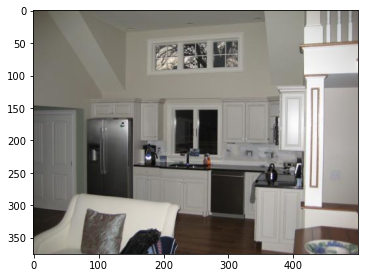

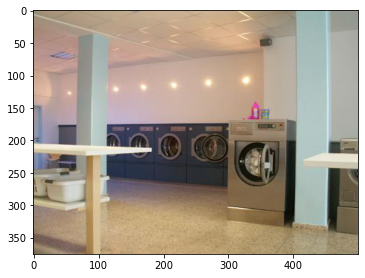

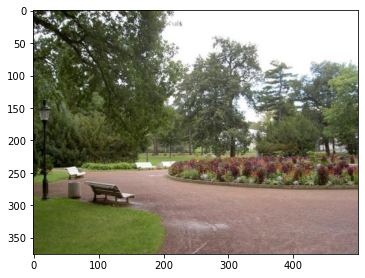

In [699]:
img1 = plt.imread("../data/" + test_files[eg1])
img2 = plt.imread("../data/" + test_files[eg2])
img3 = plt.imread("../data/" + test_files[eg3])

print("(1) Kitchen misclassified as Laundromat")
fig = plt.figure(figsize=(12.8, 4.8))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(img1)

print("(2) Laundromat misclassified as Kitchen")

fig1 = plt.figure(figsize=(12.8, 4.8))
ax1 = fig1.add_subplot(1, 2, 1)
ax1.imshow(img2)

print("(3) Park misclassified as Waterfall")

fig2 = plt.figure(figsize=(12.8, 4.8))
ax2 = fig2.add_subplot(1, 2, 1)
ax2.imshow(img3)






The most misclassified classes are Kitchen, Laundromat, and Parks. Most misclassifications are of the following type - 

(1) Kitchen misclassified as Laundromat
(2) Laundromat misclassified as Kitchen
(3) Park misclassified as Waterfall

The photos in Kitchen and laundromat classes are often misclassified as the other class. This may be because photos of both classes have similar-looking appliances, and thus have similar features.


## Q3.1



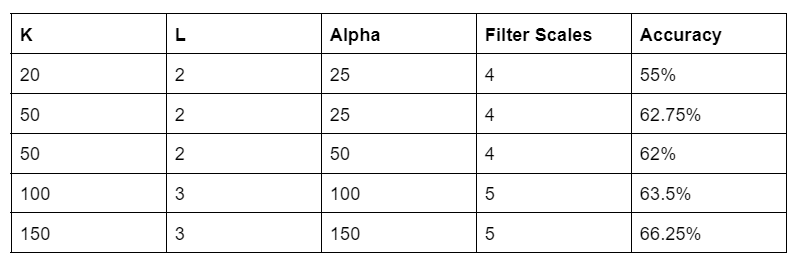

The best accuracy obtained is 66.25 %.

Following is how changing each parameter affects the accuracy - 

K - This is the number of words in the dictionary. Increasing value of K increases accuracy. This is because we can describe the images with a larger set of features/visual words.

L - Number of layers in the spatial pyramid. Increasing L leads to an increase in accuracy as finer features can be obtained.

Alpha - Number of sampled pixels when creating dictionary. Increasing value of alpha increases accuracy, as we can sample a larger number of features in each image.

Filter scales - Increasing number of filter scales increases accuracy, as we are able to obtain features at a finer level.


## Q3.2



Change (a) - Subtracting the mean colour from the image. The accuracy increased very slightly.

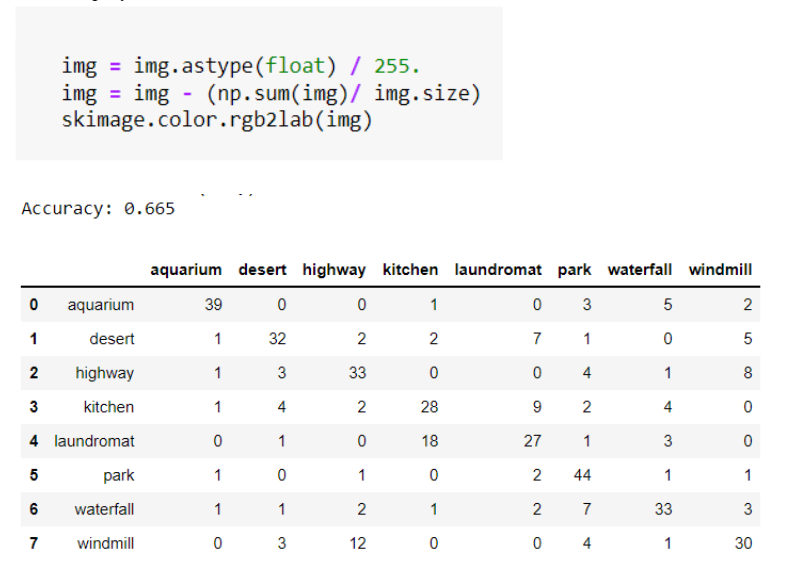


Change (b) - Reduced the size of the image by clipping the borders of the image. I expected the computation time to reduce, and the accuracy to decrease. The accuracy decreased by almost 4%.


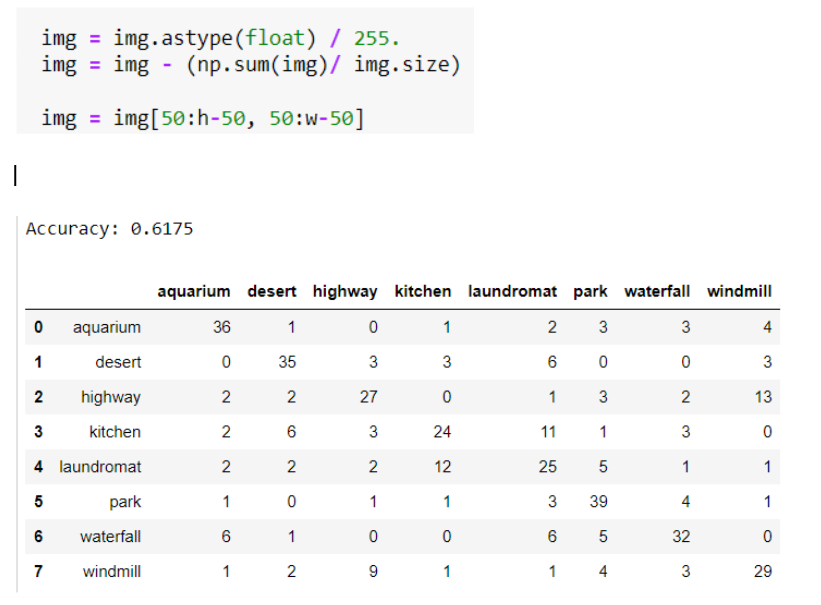

## Q3.3 (Extra Credit)

In [700]:
def compute_IDF(opts, n_worker=1):
    # YOUR CODE HERE
    pass

def evaluate_recognition_System_IDF(opts, n_worker=1):
    # YOUR CODE HERE
    pass